In [119]:
import prsoxs_xrr as xrr
import ipywidgets as widgets
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pickle

warnings.filterwarnings("ignore")

# Multi Loader

In [2]:
with open(f'{xrr.open_dialog()}', 'rb') as handle:
    xrr_data = pickle.load(handle)

PermissionError: [Errno 13] Permission denied: '.'

In [137]:
dir = xrr.file_dialog()

if dir.name == "CCD":
    xrr.xrr_sorter(dir)
    multi_dir = dir.parent.joinpath('Sorted')
elif dir.name == 'Sorted':
    multi_dir = dir

The sorted directory already exists - Checking for energy sub-directories


0it [00:00, ?it/s]

In [138]:
Energies = list(multi_dir.iterdir())
[e.name for e in Energies]

['250.0', '283.8']

In [139]:
xrr_data = {energy.name: xrr.XRR(energy) for energy in tqdm(Energies)}

  0%|          | 0/2 [00:00<?, ?it/s]

In [140]:
@widgets.interact(energy=[E.name for E in Energies])

def show_plots(energy):
    xrr = xrr_data[f"{energy}"]

    @widgets.interact(point=(0, xrr.refl.q.size - 1))
    def spot_checker(point=0):
        xrr.check_spot(point)

interactive(children=(Dropdown(description='energy', options=('250.0', '283.8'), value='250.0'), Output()), _d…

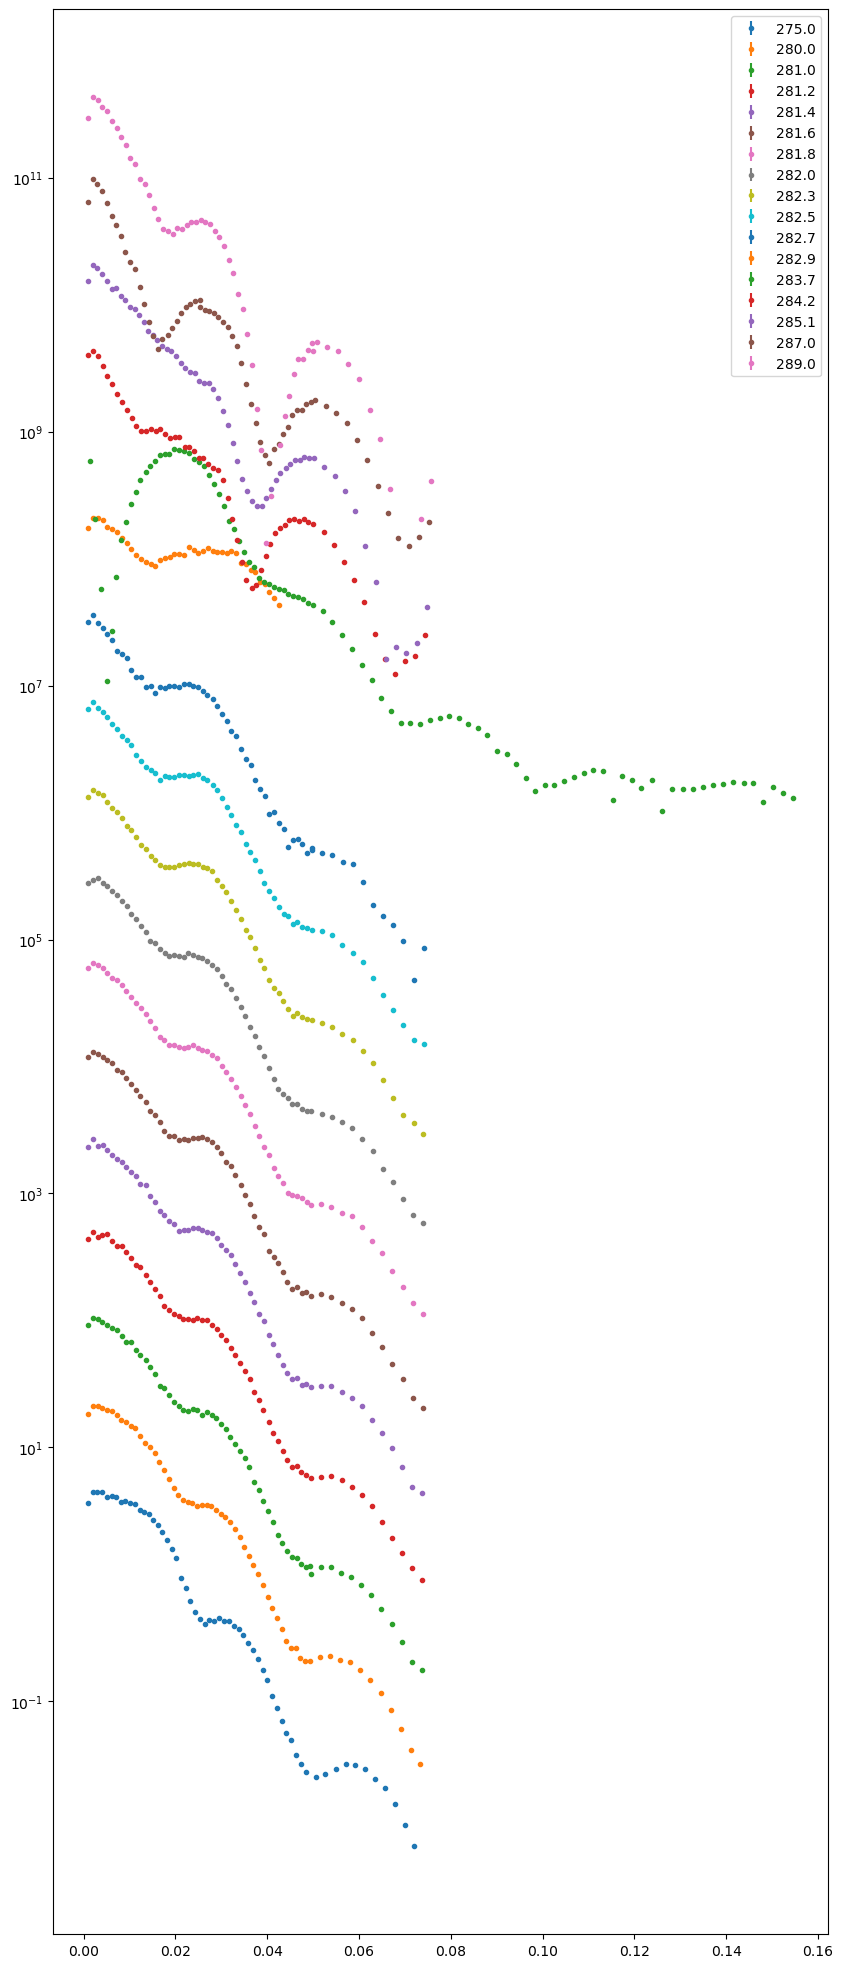

In [25]:
from uncertainties import unumpy as unp

def combine_data(xrr_data: dict, Energies: list) -> tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray], list[str]]:
    refl = []
    refl_err = []
    q = []
    energies = [E.name for E in Energies]
    for energy in energies:
        xrr = xrr_data[f"{energy}"]
        xrr.finalize()
        refl.append(unp.nominal_values(xrr.refl.r_f))
        refl_err.append(unp.std_devs(xrr.refl.r_f))
        q.append(xrr.refl.q)
    return q, refl, refl_err, energies

def combined_plot(data: tuple[list[np.ndarray], list[np.ndarray], list[np.ndarray], list[str]], scale: int) -> None:
    qs, refls, errs, names = data
    plt.figure(figsize=(10, 25))
    for i, (q, refl, err) in enumerate(zip(qs, refls, errs), start = 1):
        plt.yscale('log')
        plt.errorbar(q, refl * scale ** (i), err, fmt='.')
    plt.legend(names)
    plt.show()

def final_plot(xrr_data: dict = xrr_data, Energies: list = Energies, scale: int = 5):
    data = combine_data(xrr_data, Energies)
    combined_plot(data, scale = scale)

final_plot()

In [10]:
with open(f'{xrr.save_dialog()}.pickle', 'wb') as handle:
    pickle.dump(xrr_data, handle, protocol=pickle.HIGHEST_PROTOCOL)